Data Preparation
----------------

In [1]:
# This is in order to suppress output of annoying warnings, especially DeprecationWarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Some imports that will be needed along the way
%matplotlib inline
import csv
import pylab as pl
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import (ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.lda import LDA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
# Load data
raw_data = pd.read_csv('train.csv')
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [5]:
def prepare_data(raw_data):
    # Let's drop some columns that don't seem to be useful as features.
    # For instance, passenger ID and names are unique,
    # which means they contain no predictive information.
    # In a later step I plan to include ticket and cabin information,
    # as these are not solely unique.
    ids = raw_data.PassengerId.values
    raw_data = raw_data.drop('PassengerId', axis=1)
    raw_data = raw_data.drop('Name', axis=1)
    raw_data = raw_data.drop('Ticket', axis=1)
    raw_data = raw_data.drop('Cabin', axis=1)
    # Fill NaNs with means (we could try median here too)
    means = raw_data.mean(skipna=True)
    data = raw_data.fillna(means)
    # Fill NaNs of Embarked with most frequent value.
    # There are only two missing values in the data.
    data.Embarked = data.Embarked.fillna(data.Embarked.value_counts().index[0])
    # Replace categorical variable 'Sex' with dummies
    new_sex_column = pd.get_dummies(data.Sex, prefix='Sex')
    data = data.drop('Sex', axis=1)
    data = pd.concat((data, new_sex_column), axis=1)
    # Drop either the male or the female 'Sex' columns
    # (because information is redundant)
    data = data.rename(columns={'Sex_male': 'Sex'})
    data = data.drop('Sex_female', axis=1)
    # Replace categorical variable 'Embarked' with dummies
    new_embarked_column = pd.get_dummies(data.Embarked, prefix='Embarked')
    data = data.drop('Embarked', axis=1)
    data = pd.concat((data, new_embarked_column), axis=1)
    # Extract targets
    if hasattr(data, 'Survived'):
        y = data.Survived.values
        data = data.drop('Survived', axis=1)
        return data, data.values, y
    return data.values, ids

In [6]:
data, X, y = prepare_data(raw_data)

Let's train: `ExtraTreesClassifier`
-----------------------------------

In [7]:
clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, max_features=1.)
params = {'min_samples_leaf':[2, 3, 4],
          'min_samples_split': [1, 2, 3],
          'bootstrap': [True, False],
}
gs = GridSearchCV(clf, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [8]:
gs.best_score_, gs.best_estimator_

(0.83164983164983164,
 ExtraTreesClassifier(bootstrap=False, compute_importances=None,
            criterion='gini', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=3,
            min_samples_split=2, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0))

Out first grid search using an ExtraTreesClassifier is not bad:

In [9]:
best_estimator = ExtraTreesClassifier(
    bootstrap=False, compute_importances=None, criterion='gini', max_depth=None,
    max_features=1.0, max_leaf_nodes=None, min_density=None, min_samples_leaf=3,
    min_samples_split=2, n_estimators=500, n_jobs=1, oob_score=False,
    random_state=None, verbose=0)
best_score = 0.83164983164983164

Let's have a quick look at feature importances:

In [10]:
fi = gs.best_estimator_.feature_importances_
fi = pd.Series(data=fi, index=data.columns)
fi.sort(ascending=False)

In [11]:
fi

Sex           0.485889
Pclass        0.170495
Age           0.121230
Fare          0.101315
SibSp         0.044193
Parch         0.033130
Embarked_S    0.029518
Embarked_C    0.010747
Embarked_Q    0.003483
dtype: float64

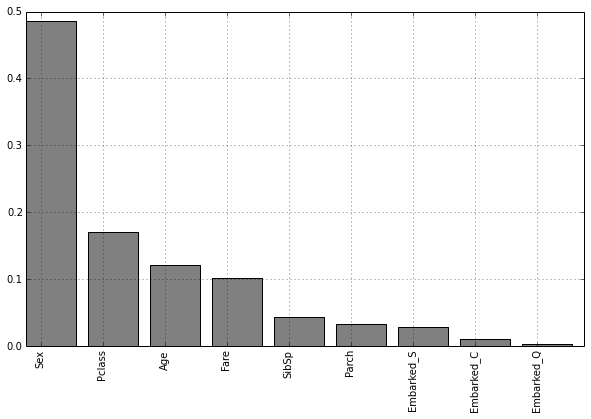

In [12]:
pl.figure(figsize=(10, 6))
pl.bar(range(len(fi)), fi.values, color=(.5, .5, .5))
pl.xticks(np.arange(len(fi)) + 0.25, fi.index, rotation=90)
pl.grid('on', 'both')

Let's have a look with PCA!
---------------------------

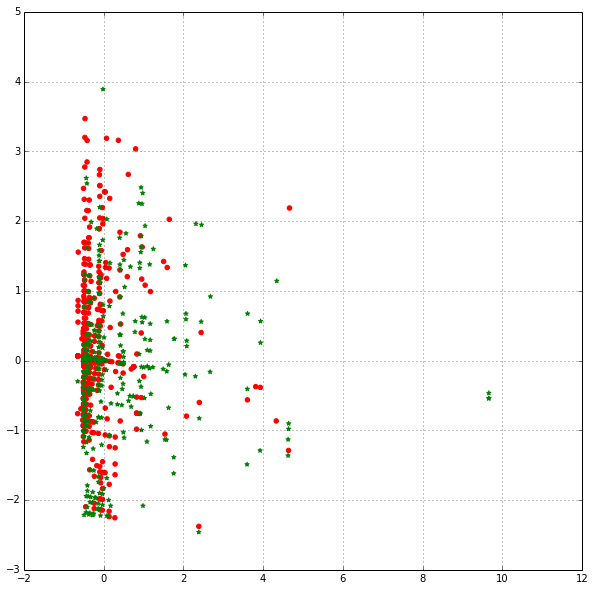

In [13]:
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X)
pl.figure(figsize=(10, 10))
c1 = X_pca[y==0, :]
c2 = X_pca[y==1, :]
pl.scatter(c1[:, 0], c1[:, 1], color='r')
pl.scatter(c2[:, 0], c2[:, 1], color='g', marker='*')
pl.grid('on', 'both')

Wow! Not separable in the first two principal components, I would say.

In [14]:
cov = np.corrcoef(np.transpose(X))

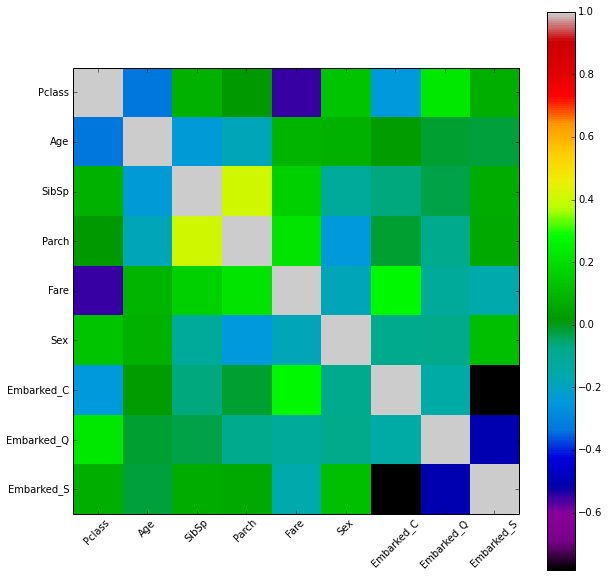

In [15]:
pl.figure(figsize=(10, 10))
pl.imshow(cov, interpolation='nearest', cmap=pl.cm.spectral)
pl.colorbar()
pl.xticks(np.arange(cov.shape[0]), data.columns, rotation=45)
pl.yticks(np.arange(cov.shape[0]), data.columns);

In [16]:
slope, intercept, r_value, p_value, std_err = linregress(data.Embarked_C, data.Embarked_S)

In [17]:
r_value, p_value

(-0.78274212871871829, 2.6786125036150505e-185)

In [18]:
slope, intercept, r_value, p_value, std_err = linregress(data.SibSp, data.Parch)
r_value, p_value

(0.41483769862015263, 2.2418236681442496e-38)

There is a high negative correlation between `Embarked_C` and `Embarked_S` (if I embarked in *S* I sure did not embark in *C*, duh!) and a positive correlation between # of siblings (`SibSp`) and # of parents/children (`Parch`).

Let's train the `ExtraTreesClassifier` on `PCA` components:

In [19]:
clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, max_features=1.)
pca = PCA(whiten=True)
params = {'clf__min_samples_leaf':[2, 3, 4],
          'clf__min_samples_split': [1, 2, 3],
          'clf__bootstrap': [True, False],
          'clf__criterion': ['gini', 'entropy'],
          'pca__n_components': np.arange(1, X.shape[1], 1)
}
pip = Pipeline([('pca', pca), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [20]:
gs.best_score_, gs.best_estimator_

(0.82828282828282829,
 Pipeline(steps=[('pca', PCA(copy=True, n_components=7, whiten=True)), ('clf', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features=1.0,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=3,
            min_samples_split=3, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0))]))

Best score using PCA (with 8 components) and `ExtraTreesClassifier` is .827 -- no improvement there.

What about LDA?
---------------

In [21]:
lda = LDA(n_components=2)
X_lda = lda.fit(X, y).transform(X)

/home/rafael/eyequant/eqpython/local/lib/python2.7/site-packages/sklearn/lda.py:161: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


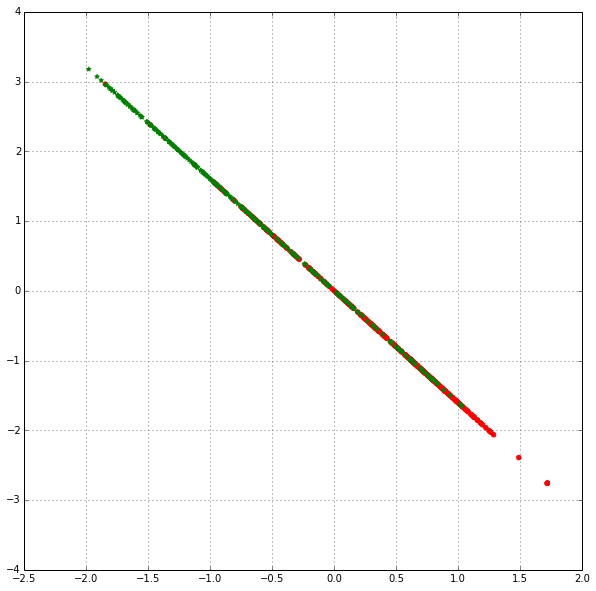

In [22]:
pl.figure(figsize=(10, 10))
c1 = X_lda[y==0, :]
c2 = X_lda[y==1, :]
pl.scatter(c1[:, 0], c1[:, 1], color='r')
pl.scatter(c2[:, 0], c2[:, 1], color='g', marker='*')
pl.grid('on', 'both')

Let's train an SVM!
-------------------

In [24]:
clf = SVC()
gamma_range = np.insert(np.logspace(-9, -1, 50), 0, 0)
C_range = np.logspace(1, 4, 50)
params = {'clf__gamma': gamma_range,
          'clf__C': C_range,
}
pip = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [25]:
gs.best_score_, gs.best_estimator_

(0.83164983164983164,
 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=40.94915062380425, cache_size=200, class_weight=None, coef0=0.0,
   degree=3, gamma=0.010481131341546853, kernel='rbf', max_iter=-1,
   probability=False, random_state=None, shrinking=True, tol=0.001,
   verbose=False))]))

In [26]:
def plot_grid(grid_search):
    """ Plot the validation score for each value of C and gamma from
         a gridsearch on an SVM.
        
        :param grid_search: A scikit-learn GridSearchCV object.
    
    """
    grid_scores = grid_search.grid_scores_
    gammas, Cs, scores = [], [], []
    gamma_str, c_str = ('clf__gamma', 'clf__C') if isinstance(
        gs.best_estimator_, Pipeline) else ('gamma', 'C')
    for grid in grid_scores:
        gammas.append(grid.parameters[gamma_str])
        Cs.append(grid.parameters[c_str])
        scores.append(grid.mean_validation_score)
    gammas = np.asarray(gammas)
    Cs = np.asarray(Cs)
    scores = np.asarray(scores)
    scores = scores.reshape(len(C_range), len(gamma_range))
    pl.figure(figsize=(10,10))
    pl.imshow(scores, interpolation='nearest', cmap=pl.cm.spectral)
    pl.xlabel('gamma')
    pl.ylabel('C')
    pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    pl.yticks(np.arange(len(C_range)), C_range)
    pl.colorbar()

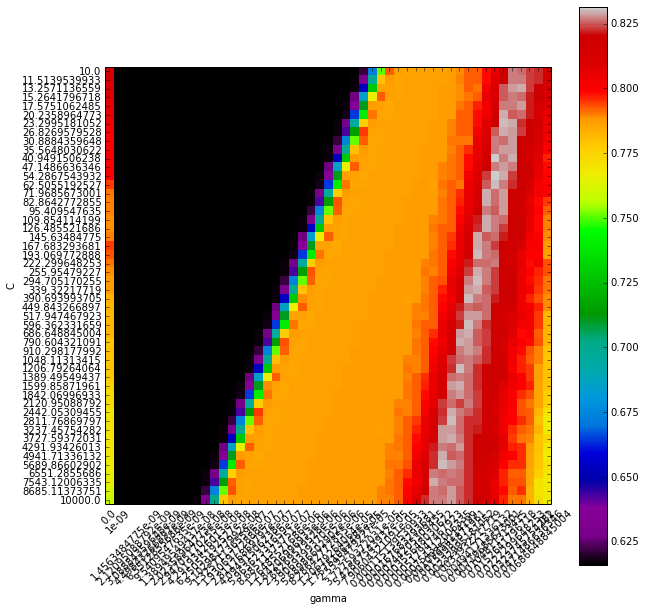

In [27]:
plot_grid(gs)

In [28]:
clf = SVC()
gamma_range = np.insert(np.logspace(-5, 1, 30), 0, 0)
C_range =np.logspace(1, 5, 30)
params = {'clf__gamma': gamma_range,
          'clf__C': C_range,
}
pip = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [29]:
gs.best_score_, gs.best_estimator_

(0.83164983164983164,
 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=35.622478902624422, cache_size=200, class_weight=None, coef0=0.0,
   degree=3, gamma=0.01268961003167922, kernel='rbf', max_iter=-1,
   probability=False, random_state=None, shrinking=True, tol=0.001,
   verbose=False))]))

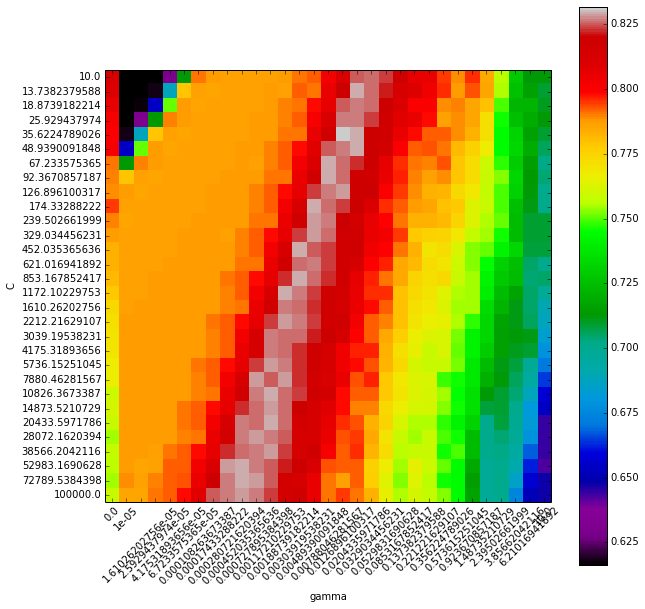

In [30]:
plot_grid(gs)

In [31]:
best_estimator = Pipeline(
steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
       ('clf', SVC(C=35.622478902624422, cache_size=200, class_weight=None, coef0=0.0,
                   degree=3, gamma=0.01268961003167922, kernel='rbf', max_iter=-1,
                   probability=False, random_state=None, shrinking=True, tol=0.001,
                   verbose=False))])
best_score = 0.83164983164983164

SVC performance is equivalent to `ExtraTreesClassifier`.

Let's try the last one: `GradientBoostingClassifier`!
-----------------------------------------------------

In [32]:
clf = GradientBoostingClassifier(n_estimators=500)
params = {'clf__max_depth': [7, 8],
          'clf__max_features': [0.9, 0.8],
          'clf__min_samples_leaf':[6, 7],
          'clf__min_samples_split': [1, 2],
          'clf__subsample': [0.9, 0.8, 0.7],
          'clf__learning_rate': [0.001, 0.002]
}
pip = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [33]:
gs.best_score_, gs.best_estimator_

(0.84175084175084181,
 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(init=None, learning_rate=0.002, loss='deviance',
               max_depth=8, max_features=0.9, max_leaf_nodes=None,
               min_samples_leaf=6, min_samples_split=2, n_estimators=500,
               random_state=None, subsample=0.7, verbose=0,
               warm_start=False))]))

In [34]:
best_estimator = Pipeline(
    steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('clf', GradientBoostingClassifier(init=None, learning_rate=0.001, loss='deviance',
               max_depth=7, max_features=0.8, max_leaf_nodes=None,
               min_samples_leaf=6, min_samples_split=1, n_estimators=2000,
               random_state=None, subsample=0.7, verbose=0,
               warm_start=False))])
best_score = 0.84175084175084181

In the leaderboard this classifier only gives 0.77512! :( Let's improve.

Feature Union
-------------

In [35]:
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.pipeline import FeatureUnion

In [36]:
# PCA
pca = PCA(n_components=9, whiten=True)
# LDA
lda = LDA(n_components=2)
# VarianceThreshold
var_thr = VarianceThreshold(threshold=np.percentile(X.std(axis=0), 75))
feature_union = FeatureUnion([('pca', pca), ('lda', lda), ('var_thr', var_thr)])

In [37]:
clf = GradientBoostingClassifier(n_estimators=1000)
params = {'clf__max_depth': [8],
          'clf__max_features': [0.9, 0.8],
          'clf__min_samples_leaf':[7],
          'clf__min_samples_split': [2, 3],
          'clf__subsample': [0.9, 0.8],
          'clf__learning_rate': [0.001, 0.002]
}
pip = Pipeline([('union', feature_union), ('scaler', StandardScaler()), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [38]:
gs.best_score_

0.81930415263748602

Nope, no improvement. I would like to test it with Random Forests:

In [39]:
clf = RandomForestClassifier(n_estimators=500)
params = {'clf__max_depth': [7, 8, 9],
          'clf__max_features': [1., .9],
          'clf__min_samples_leaf':[1, 2],
          'clf__min_samples_split': [2, 3],
          'clf__bootstrap': [True],
          'clf__criterion': ['gini', 'entropy']
}
pip = Pipeline([('union', feature_union), ('scaler', StandardScaler()), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [40]:
gs.best_score_, gs.best_estimator_

(0.82379349046015715, Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
        transformer_list=[('pca', PCA(copy=True, n_components=9, whiten=True)), ('lda', LDA(n_components=2, priors=None)), ('var_thr', VarianceThreshold(threshold=1.1021244350892836))],
        transformer_weights=None)), ('scaler', StandardScaler(copy=True, wit...es_split=3, n_estimators=500, n_jobs=1,
             oob_score=False, random_state=None, verbose=0))]))

This estimator gives us a 0.78947 in the leaderboard. For more significant increase, I think we need to do something about the features. Let's have a look at them.

In [41]:
# Load data
raw_data = pd.read_csv('train.csv')

Name Feature
------------

In [42]:
def get_name_titles(raw_data):
    values = ['Mr.', 'Miss', 'Master', 'Mrs', 'Don', 'Dr.', 'Rev', 'Major', 'Ms',
              'Mlle', 'Sir', 'Col', 'Countess', 'Mme', 'Jonkheer', 'Capt.']
    names = raw_data.Name
    titles = []
    for i, name in enumerate(names):
        for title in values:
            if title in name:
                titles.append(title)
                break
    titles = pd.DataFrame(titles, index=raw_data.index)
    # I am going to keep Mr, Miss, Master and Mrs. The others I will
    # assign either to one of the others, depending on what makes more sense.
    titles[titles == 'Don'] = 'Mr.'
    titles[titles == 'Dr.'] = 'Mr.'
    titles[titles == 'Rev'] = 'Mr.'
    titles[titles == 'Major'] = 'Mr.'
    titles[titles == 'Ms'] = 'Miss'
    titles[titles == 'Mlle'] = 'Miss'
    titles[titles == 'Sir'] = 'Mr.'
    titles[titles == 'Col'] = 'Mr.'
    titles[titles == 'Countess'] = 'Miss'
    titles[titles == 'Mme'] = 'Mrs'
    titles[titles == 'Jonkheer'] = 'Mr.'
    titles[titles == 'Capt.'] = 'Mr.'
    return titles



In [43]:
def prepare_data2(raw_data):
    # Let's drop some columns that don't seem to be useful as features.
    # For instance, passenger ID and names are unique,
    # which means they contain no predictive information.
    # In a later step I plan to include ticket and cabin information,
    # as these are not solely unique.
    ids = raw_data.PassengerId.values
    raw_data = raw_data.drop('PassengerId', axis=1)
    raw_data = raw_data.drop('Ticket', axis=1)
    raw_data = raw_data.drop('Cabin', axis=1)
    # Fill NaNs with means (we could try median here too)
    means = raw_data.mean(skipna=True)
    data = raw_data.fillna(means)
    # Fill NaNs of Embarked with most frequent value.
    # There are only two missing values in the data.
    data.Embarked = data.Embarked.fillna(data.Embarked.value_counts().index[0])
    # Replace categorical variable 'Sex' with dummies
    new_sex_column = pd.get_dummies(data.Sex, prefix='Sex')
    data = data.drop('Sex', axis=1)
    data = pd.concat((data, new_sex_column), axis=1)
    # Drop either the male or the female 'Sex' columns (because information is redundant)
    data = data.rename(columns={'Sex_male': 'Sex'})
    data = data.drop('Sex_female', axis=1)
    # Replace categorical variable 'Embarked' with dummies
    new_embarked_column = pd.get_dummies(data.Embarked, prefix='Embarked')
    data = data.drop('Embarked', axis=1)
    data = pd.concat((data, new_embarked_column), axis=1)
    # Names
    names = get_name_titles(data)
    new_name_column = pd.get_dummies(names[0], prefix='Name')
    data = data.drop('Name', axis=1)
    data = pd.concat((data, new_name_column), axis=1)
    # Extract targets
    if hasattr(data, 'Survived'):
        y = data.Survived.values
        data = data.drop('Survived', axis=1)
        return data.values, y
    return data.values, ids

In [44]:
# Load data
raw_data = pd.read_csv('train.csv')
X, y = prepare_data2(raw_data)

In [45]:
# PCA
pca = PCA(n_components=4, whiten=True)
# LDA
lda = LDA(n_components=2)
# VarianceThreshold
var_thr = VarianceThreshold(threshold=np.percentile(X.std(axis=0), 55))
# SelectKBest
k_best = SelectKBest(chi2, k=7)
feature_union = FeatureUnion([('pca', pca), ('lda', lda), ('var_thr', var_thr)])

In [46]:
clf = RandomForestClassifier(n_estimators=1000)
params = {'clf__max_depth': [7, 8, 9],
          'clf__max_features': [1., .9],
          'clf__min_samples_leaf':[1, 2],
          'clf__min_samples_split': [2, 3, 4],
          'clf__bootstrap': [True],
          'clf__criterion': ['gini', 'entropy']
}
pip = Pipeline([('union', feature_union), ('scaler', StandardScaler()), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [47]:
gs.best_score_

0.83950617283950613

In [48]:
def prepare_data3(raw_data, age_means=None):
    raw_data = raw_data.drop('PassengerId', axis=1)
    raw_data = raw_data.drop('Ticket', axis=1)
    raw_data = raw_data.drop('Cabin', axis=1)
    # Names
    names = get_name_titles(raw_data)
    new_name_column = pd.get_dummies(names[0], prefix='Name')
    data = raw_data.drop('Name', axis=1)
    data = pd.concat((data, new_name_column), axis=1)
    # Fill NaNs of Embarked with most frequent value.
    # There are only two missing values in the data.
    data.Embarked = data.Embarked.fillna(data.Embarked.value_counts().index[0])
    # Replace categorical variable 'Sex' with dummies
    new_sex_column = pd.get_dummies(data.Sex, prefix='Sex')
    data = data.drop('Sex', axis=1)
    data = pd.concat((data, new_sex_column), axis=1)
    # Drop either the male or the female 'Sex' columns (because information is redundant)
    data = data.rename(columns={'Sex_male': 'Sex'})
    data = data.drop('Sex_female', axis=1)
    # Replace categorical variable 'Embarked' with dummies
    new_embarked_column = pd.get_dummies(data.Embarked, prefix='Embarked')
    data = data.drop('Embarked', axis=1)
    data = pd.concat((data, new_embarked_column), axis=1)
    # Age fill Nan
    if age_means is None:
        age_means = data.groupby(
            ['Name_Master', 'Name_Mr.', 'Name_Mrs', 'Name_Miss']).mean().Age
    ages = []
    for i, row in data.iterrows():
        if np.isnan(row['Age']):
            if row['Name_Master'] == 1:
                ages.append(age_means.values[3])
            elif row['Name_Miss'] == 1:
                ages.append(age_means.values[2])
            elif row['Name_Mr.'] == 1:
                ages.append(age_means.values[1])
            elif row['Name_Mrs'] == 1:
                ages.append(age_means.values[0])
            else:
                ages.append(np.mean(age_means))
        else:
            ages.append(row['Age'])
    data['Age'] = pd.Series(ages, index=data.index)
    # Fill still missing NaNs with means (we could try median here too)
    means = data.mean(skipna=True)
    data = data.fillna(means)
    # Extract targets
    if hasattr(data, 'Survived'):
        y = data.Survived.values
        data = data.drop('Survived', axis=1)
        return data, y, age_means
    return data.values, ids

In [49]:
# Load data
raw_data = pd.read_csv('train.csv')
X, y, age_means = prepare_data3(raw_data)

In [50]:
# PCA
pca = PCA(n_components=4, whiten=True)
# LDA
lda = LDA(n_components=2)
# VarianceThreshold
var_thr = VarianceThreshold(threshold=np.percentile(X.std(axis=0), 90))
# SelectKBest
k_best = SelectKBest(chi2, k=7)
feature_union = FeatureUnion([('pca', pca), ('lda', lda), ('var_thr', var_thr)])

In [51]:
clf = RandomForestClassifier(n_estimators=500)
params = {'clf__max_depth': [6, 7, 8],
          'clf__max_features': [.9, .5, .3],
          'clf__min_samples_leaf':[1, 2],
          'clf__min_samples_split': [2, 3],
          'clf__bootstrap': [True],
          'clf__criterion': ['gini', 'entropy']
}
pip = Pipeline([('union', feature_union), ('clf', clf)])
gs = GridSearchCV(pip, params, cv=5, n_jobs=-1)
gs.fit(X, y);

In [52]:
gs.best_score_

0.8271604938271605

Predict
-------

In [ ]:
test_data = pd.read_csv('test.csv')
X_test, ids = prepare_data3(test_data, age_means=age_means)

In [ ]:
test_data = pd.read_csv('test.csv')
X_test, ids = prepare_data3(test_data)
predictions = gs.best_estimator_.predict(X_test)
with open('predictions.csv', 'w') as fp:
    a = csv.writer(fp, delimiter=',')
    header = ['PassengerId', 'Survived'],
    a.writerows(header)
    a.writerows(zip(ids, predictions))